In [1]:
import csv
import matplotlib.pyplot as plt
from datetime import date
import numpy as np

In [2]:
pitstops = []

def sanitize(entry):
    entry['Type'] = entry['Type'].lower()
    # do more?
    return entry

# file format
# Date,Time,Type,Amount,Price,Chain,Location,Relative,Absolute

# read file as standard csv file and add each entry to list
with open('data/data.csv') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for entry in csvreader:
        if len(entry) != 9:
            print('Invalid format in line:', ','.join(entry))
            continue
        # TODO: sorted insertion
        pitstops.append(sanitize(entry))

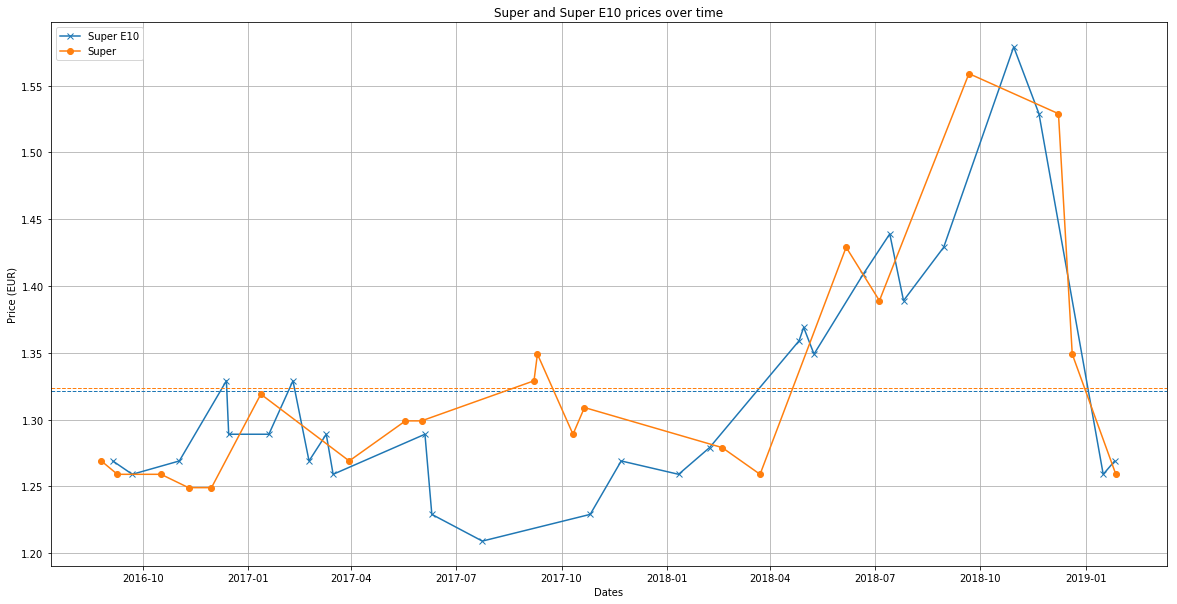

In [6]:
# show prices of Super E10 vs Super over time

fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)

ax.set(xlabel='Dates', ylabel='Price (EUR)', title='Super and Super E10 prices over time')
ax.grid()

prices_e10 = [ float(p['Price']) for p in pitstops if p['Type'] == 'super e10']
dates_e10 = [date.fromisoformat(p['Date']) for p in pitstops if p['Type'] == 'super e10']
ax.plot(dates_e10, prices_e10, label='Super E10', marker='x')

average_e10 = sum(prices_e10) / len(prices_e10)
ax.axhline(average_e10, color='tab:blue', linestyle='dashed', linewidth=1)

prices_super = [ float(p['Price']) for p in pitstops if p['Type'] == 'super']
dates_super = [date.fromisoformat(p['Date']) for p in pitstops if p['Type'] == 'super']
ax.plot(dates_super, prices_super, label='Super', marker='o')

average_super = sum(prices_super) / len(prices_super)
ax.axhline(average_super, color='tab:orange', linestyle='dashed', linewidth=1)

ax.legend(loc='upper left')

plt.show()

In [53]:
# total amount of super vs e10

fig, ax = plt.subplots()

amount_e10 = sum( [ float( p['Amount'] ) for p in pitstops if p['Type'] == 'super e10'] )
amount_super = sum( [ float( p['Amount'] ) for p in pitstops if p['Type'] == 'super'] )
total_amount = amount_e10 + amount_super

ax.set(title='Amount of Super and Super E10 fueled (Total: %.0fL)' % total_amount)

ax.pie([amount_super, amount_e10], labels=['Super: %.0fL' % amount_super, 'Super E10: %.0fL' % amount_e10], autopct='%1.1f%%' )

plt.show()

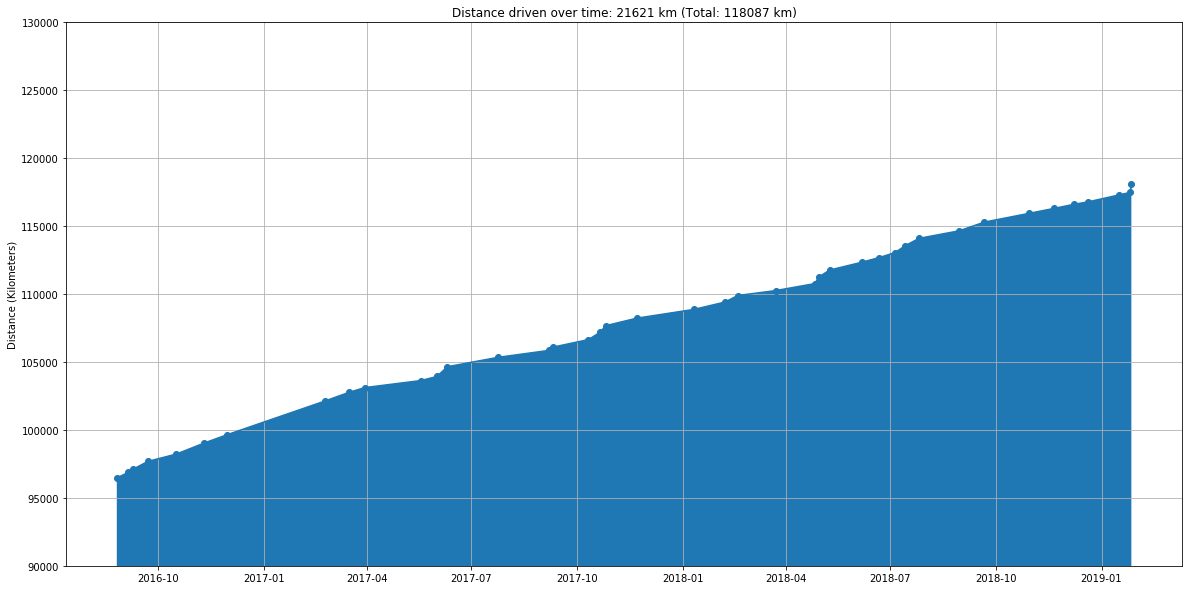

In [26]:
# total driven kilometers

fig, ax = plt.subplots()

fig.set_figwidth(20)
fig.set_figheight(10)
ax.grid()
# TODO: automatically determine limits
plt.ylim(bottom=90000, top=130000)

distances = [ int(p['Absolute']) for p in pitstops if p['Absolute'] != '0' ]
dates = [ date.fromisoformat(p['Date']) for p in pitstops if p['Absolute'] != '0' ]
ax.plot(dates, distances, label='Super E10', marker='o')
ax.fill_between(dates, 0, distances)
ax.set(ylabel='Distance (Kilometers)', title='Distance driven over time: %d km (Total: %d km)' % (distances[-1]-distances[0], distances[-1]) )

plt.show()

In [40]:
# plot how many kilometers are usually driven / liters fueled

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

# kilometers driven between pitstops
relative = [ int(float(p['Relative'])) for p in pitstops if p['Relative'] != '0' ]
ax1.hist(relative, bins=range(0, 1000, 100))

# draw average fuel as dashed line
relative_avg = sum(relative) / len(relative)
ax1.axvline(relative_avg, color='k', linestyle='dashed', linewidth=1)
ax1.set(xlabel='Kilometers driven', ylabel='Occurences', title='How many kilometers are usually driven (Average: %.0f)' % relative_avg)

# liters fueled at each pitstop
amount = [ int(float(p['Amount'])) for p in pitstops ]
ax2.hist(amount, bins=range(min(amount), max(amount) + 5, 5))

# draw average amount as dashed line
amount_avg = sum(amount) / len(amount)
ax2.axvline(amount_avg, color='k', linestyle='dashed', linewidth=1)
ax2.set(xlabel='Liters fueled', ylabel='Occurences', title='How many liters are usually fueled (Average: %.1f)' % amount_avg)

# days between pitstops
dates = np.array( [ date.fromisoformat(p['Date']) for p in pitstops ] )
diffs = np.diff(dates)
ax3.hist( [ d.days for d in diffs ], bins=30)

# draw average amount as dashed line
diff_avg = np.sum(diffs) / len(diffs)
ax3.axvline(diff_avg.days, color='k', linestyle='dashed', linewidth=1)
ax3.set(xlabel='Days', ylabel='Occurences', title='Time between Pitstops (Average: %.0f Days)' % diff_avg.days)

plt.show()

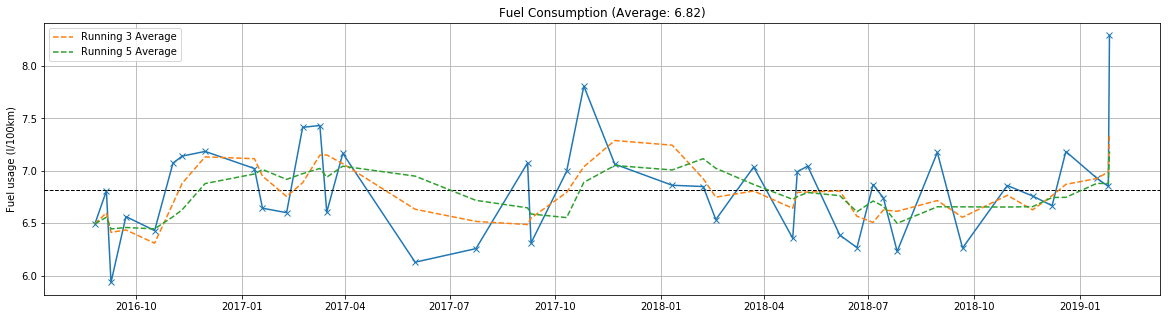

In [24]:
# calculate fuel usage (l/100km)

fig, ax = plt.subplots()

fig.set_figwidth(20)
fig.set_figheight(5)
ax.grid()

usage = [ float(p['Amount'])/float(p['Relative'])*100 for p in pitstops if p['Relative'] != '0' ]
dates = [ date.fromisoformat(p['Date']) for p in pitstops if p['Relative'] != '0' ]
ax.plot(dates, usage, marker='x')

# draw average amount as dashed line
usage_avg = sum(usage) / len(usage)
ax.axhline(usage_avg, color='k', linestyle='dashed', linewidth=1)

# running k-average
def running_k_average(values, k):
    if len(values) < k:
        return []
    
    r = np.repeat(usage[0], k)
    
    average = np.zeros(shape=len(values))
    for idx, val in enumerate(usage):
        # remove old value and append new one
        r = np.concatenate( (r[1:k], (val,)) )
    
        # calculate average
        average[idx] = sum(r) / k
    
    return average
    
ax.plot(dates, running_k_average(usage, 3), linestyle='dashed', label='Running 3 Average')

ax.plot(dates, running_k_average(usage, 5), linestyle='dashed', label='Running 5 Average')
    
ax.set(ylabel='Fuel usage (l/100km)', title='Fuel Consumption (Average: %.2f)' % usage_avg)
ax.legend(loc='upper left')

plt.show()